In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import timeit
import pysindy as ps
import pandas as pd
import io
import sys

In [2]:
def alphalap(u, alpha):
    utilde=np.fft.fftn(u)
    alphalap=np.real(np.fft.ifftn(-k2**(alpha/2)*utilde))
    return alphalap

def fractionaldiffusion(t,u, alpha):
    lap=alphalap(u.reshape((n,n)),alpha)
    return lap.ravel()

In [3]:
n=128
L=10
T=1.0
nt=201
t = np.linspace(0, T, nt)
dt = T / (nt - 1)
alpha = 3

#define these first so they don't have to be reallocated each step
k=np.zeros((n,n,2)) 
k[:n//2+1,:,0]=2*np.pi/(L)*np.arange(n//2+1)[:,np.newaxis]
k[n//2+1:,:,0]=2*np.pi/(L)*(1-n//2+np.arange(n//2-1)[:,np.newaxis])
k[:,:n//2+1,1]=2*np.pi/(L)*np.arange(n//2+1)[np.newaxis,:]
k[:,n//2+1:,1]=2*np.pi/(L)*(1-n//2+np.arange(n//2-1)[np.newaxis,:])
k2=(k[:,:,0]**2+k[:,:,1]**2)

# construct S-grid
spatial_grid = np.zeros((n, n, 2))
spatial_grid[:, :, 0] = np.arange(n)[:, np.newaxis] * L / n
spatial_grid[:, :, 1] = np.arange(n)[np.newaxis, :] * L / n

# Construct ST-grid
x = np.arange(n)*L/n
y = np.arange(n)*L/n
X, Y, time = np.meshgrid(x, y, t)
XY = np.asarray([X, Y, time])
spatiotemporal_grid = np.transpose(XY, axes=[2, 1, 3, 0])

print("ST shape:", np.shape(spatiotemporal_grid))

ST shape: (128, 128, 201, 3)


0
1
2


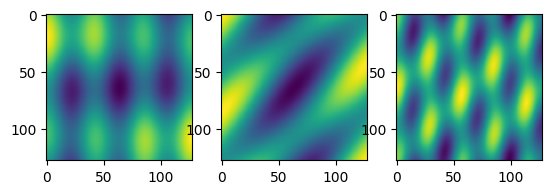

In [4]:
# Generate random train trajectories
num_train_traj = 3

train_trajs = []
IC = []
for i in range(num_train_traj):
    print(i)
    # define IC
    const = np.random.randint(10)
    v1 = np.random.randint(10)
    v2 = np.random.randint(10)
    v3 = np.random.randint(10)
    
    u0=const+(np.sin(v1*np.pi*np.arange(n)[:,np.newaxis]/n)+np.cos(v2*np.pi*np.arange(n)[np.newaxis,:]/n)+np.cos(v3*np.pi*(np.arange(n)[np.newaxis,:]/n+np.arange(n)[:,np.newaxis]/n)))
    IC.append(u0)

    usol0 = solve_ivp(
        fractionaldiffusion, (0, T), y0=u0.ravel(), t_eval=t, 
        args=(alpha,), method='RK45', rtol=1e-6, atol=1e-6,
    )
    
    train_trajs.append(usol0.y.reshape(n, n, nt, 1))

np.save("train_traj", train_trajs)

fig, axes = plt.subplots(1, num_train_traj)
for i in range(num_train_traj):
    axes[i].imshow(IC[i])
fig.title("train_traj")

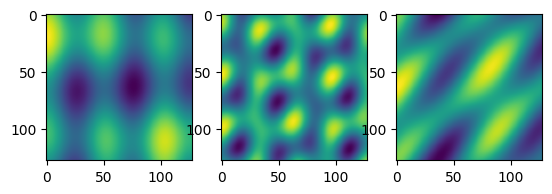

In [5]:
# Generate random test trajectories
num_test_traj = 3

test_trajs = []
IC = []
for i in range(num_train_traj):
    # define IC
    const = np.random.randint(10)
    v1 = np.random.randint(10)
    v2 = np.random.randint(10)
    v3 = np.random.randint(10)
    
    u0=const+(np.sin(v1*np.pi*np.arange(n)[:,np.newaxis]/n)+np.cos(v2*np.pi*np.arange(n)[np.newaxis,:]/n)+np.cos(v3*np.pi*(np.arange(n)[np.newaxis,:]/n+np.arange(n)[:,np.newaxis]/n)))
    IC.append(u0)
    
    usol0 = solve_ivp(
        fractionaldiffusion, (0, T), y0=u0.ravel(), t_eval=t, 
        args=(alpha,), method='RK45', rtol=1e-6, atol=1e-6,
    )
    
    test_trajs.append(usol0.y.reshape(n, n, nt, 1))

np.save("test_traj", test_trajs)

fig, axes = plt.subplots(1, num_train_traj)
for i in range(num_train_traj):
    axes[i].imshow(IC[i])
fig.title("test_traj")

In [ ]:
# define sindy params
library_functions = []
library_function_names = []

nonloc_lib = ps.NonlocPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2, spatiotemporal_grid=spatiotemporal_grid,
    include_bias=True, differentiation_method=ps.SpectralDerivative, K = [2, 2]
)

optimizer = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)

# make thee models
model = ps.SINDy(feature_library=nonloc_lib, optimizer=optimizer)

# fit thee models
model.fit(train_trajs, t=dt, multiple_trajectories = True)

# save thee scores of thee models
for i in range(num_test_traj):
    print(model.score(test_trajs[i], t=dt))


Predicted Num nonloc feature: 16


In [ ]:
results = []

for i in range(len(alpha)):
    print(i)
    row = {"alpha": alpha[i]}

    # define sindy params
    library_functions = []
    library_function_names = []

    pde_lib = ps.PDELibrary(
        library_functions=library_functions, 
        function_names=library_function_names, 
        derivative_order=2, spatial_grid=spatial_grid, 
        include_bias=True, differentiation_method=ps.SpectralDerivative
    )
    
    optimizer = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)

    # make thee models
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

    # fit thee models
    model.fit(usol0[i].y.reshape(n, n, nt, 1), t=dt)

    # save thee scores of thee models
    row["train score"] = model.score(usol0[i].y.reshape(n, n, nt, 1), t=dt)
    row["test score"] = model.score(usol1[i].y.reshape(n, n, nt, 1), t=dt)

    # Create a buffer to capture the printed output
    output_buffer = io.StringIO()

    # Redirect the standard output to the buffer
    sys.stdout = output_buffer

    # Print something (it will go to the buffer instead of the console)
    model.print()

    # Reset the standard output to its original value
    sys.stdout = sys.__stdout__

    # Fetch the printed line into a variable
    printed_line = output_buffer.getvalue()

    # close the buffer
    output_buffer.close()

    row["eqn"] = printed_line

    results.append(row)

df = pd.DataFrame(results)
df.to_excel("pded2.xlsx", index=False)


In [ ]:
results = []

for i in range(len(alpha)):
    print(i)
    row = {"alpha": alpha[i]}

    # define sindy params
    library_functions = []
    library_function_names = []

    pde_lib = ps.PDELibrary(
        library_functions=library_functions, 
        function_names=library_function_names, 
        derivative_order=3, spatial_grid=spatial_grid, 
        include_bias=True, differentiation_method=ps.SpectralDerivative
    )
    
    optimizer = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)

    # make thee models
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

    # fit thee models
    model.fit(usol0[i].y.reshape(n, n, nt, 1), t=dt)\

    # save thee scores of thee models
    row["train score"] = model.score(usol0[i].y.reshape(n, n, nt, 1), t=dt)
    row["test score"] = model.score(usol1[i].y.reshape(n, n, nt, 1), t=dt)

    # Create a buffer to capture the printed output
    output_buffer = io.StringIO()

    # Redirect the standard output to the buffer
    sys.stdout = output_buffer

    # Print something (it will go to the buffer instead of the console)
    model.print()

    # Reset the standard output to its original value
    sys.stdout = sys.__stdout__

    # Fetch the printed line into a variable
    printed_line = output_buffer.getvalue()

    # close the buffer
    output_buffer.close()

    row["eqn"] = printed_line

    results.append(row)

df = pd.DataFrame(results)
df.to_excel("pded3.xlsx", index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data1 = pd.read_excel("results.xlsx")
data2 = pd.read_excel("nonloc_results.xlsx")

alpha = data1["alpha"]
st1 = data1["solve time"]
st2 = data2["solve time"]

plt.plot(alpha, st1, label="pde")
plt.plot(alpha, st2, label="nonloc")
plt.legend()
plt.show()

In [ ]:
sc1 = data1["score"]
sc2 = data2["score"]

plt.plot(alpha, sc1, label="pde")
plt.plot(alpha, sc2, label="nonloc")